In [1]:
import contacts as ct
import graphprocessing as gp
import clustering as cl
import graphmining as gm
import common as cm
import logging
#import graphmatcher as matcher
import networkx as nx
import sys
import json
from pathlib import Path              
import numpy as np
import os
from networkx.algorithms import isomorphism
import networkx as nx
from collections import Counter
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans

GSPANPATH = os.getcwd() + "/gSpan/gSpan-64"
if __name__ == '__main__': 
    
    interactions,int_list = ct.readInteractions("interactions.csv")
    a_types,a_type_list = ct.readAtom_Types("atom_types.csv")
    typeCode = cm.TypeCode(a_type_list,int_list)
    typenames = cm.TypeMap("typenames.json")
    path = Path("gSpan/") 
    path.mkdir(parents=True,exist_ok=True)
    path = str(path)
    logging.basicConfig(level=logging.DEBUG)

In [2]:
############## Data Graph
logging.info("---Read graphs file <<DataGraphs>>---")
dgraphs,dnode_labels,dedge_labels = gp.read_graphs('dgraphs.txt',path=path)

############## Query Graph
logging.info("---Read graphs file <<DataGraphs>>---")
qgraphs,qnode_labels,qedge_labels = gp.read_graphs('qgraphs.txt',path=path)


############## Test Graph
logging.info("---Read graphs file <<TestGraphs>>---")
tgraphs,tnode_labels,tedge_labels = gp.read_graphs('tgraphs.txt',path=path)

INFO:root:---Read graphs file <<DataGraphs>>---
INFO:root:---Read graphs file <<DataGraphs>>---
INFO:root:---Read graphs file <<TestGraphs>>---


In [3]:
# qgraphs on data graphs = all positive dataGraphPattern and all negative dataGraphPattern
logging.info("--- qgraphs on data graphs = all positive dataGraphPattern and all negative dataGraphPattern ---")
dgraphs1 = dgraphs
qgraphs1 = qgraphs

notIso = []  
notIsoD = dict()
Iso = []
IsoD = dict()

print("dgraphs:", len(dgraphs1))
for query in qgraphs1:
    for graph in dgraphs1:
        g1, g2 = graph, query
        
        if g1.number_of_nodes() < g2.number_of_nodes():
            g1, g2 = g2, g1
        
        GM = isomorphism.GraphMatcher(g1, g2)
        is_isomorphic = GM.is_isomorphic()

        if is_isomorphic:
            Iso.append(graph)
            IsoD[graph.graph['id']] = graph
        else:
            notIso.append(graph)
            notIsoD[graph.graph['id']] = graph
        
    
    isoD2 = notIsoD.copy()
    notIsoD.clear()
    dgraphs1 = []
    dgraphs1 = notIso
    notIso = []


allposdict = {}
allposlist = []
allnegdict = {}
allneglist = []
allposdict.update(IsoD)
allposlist = Iso
allnegdict.update(isoD2)
allneglist = dgraphs1

print("All Positive Dictionary:", len(allposdict))
print("All Positive List:", len(allposlist))
print("All Negative Dictionary:", len(allnegdict))
print("All Negative List:", len(allneglist))

INFO:root:--- qgraphs on data graphs = all positive dataGraphPattern and all negative dataGraphPattern ---


dgraphs: 115225
All Positive Dictionary: 109163
All Positive List: 109163
All Negative Dictionary: 6062
All Negative List: 6062


In [4]:
# Keep the raw process file
logging.info("---Keep the raw process file---")
allposdict2 = {}
allposlist2 = []
allnegdict2 = {}
allneglist2 = []
allposdict2.update(allposdict)
allposlist2= allposlist
allnegdict2.update(allnegdict)
allneglist2 = allneglist

INFO:root:---Keep the raw process file---


In [5]:
# test graphs on all positive dataGraphPattern = TP + FN
logging.info("---Test graphs on all positive dataGraphPattern = TP + FN ---")
PnotIso = []  
PnotIsoD = dict()
PIso = []
PIsoD = dict()
tgraphs1 = tgraphs

print("allpositive:", len(allposdict2))

for test in tgraphs1:
    for k, pattern in allposdict2.items():
        g1, g2 = pattern, test
        
        if g1.number_of_nodes() < g2.number_of_nodes():
            g1, g2 = g2, g1
            
        
        # Check for subgraph isomorphism
        GM = isomorphism.GraphMatcher(g1, g2)
        is_isomorphic = GM.is_isomorphic()

        if is_isomorphic:
            PIso.append(pattern)
            PIsoD[k] = pattern
        else:
            PnotIso.append(pattern)
            PnotIsoD[k] = pattern

    PnotIsoD2 = PnotIsoD.copy()
    allposdict2.clear()
    allposdict2.update(PnotIsoD)
    PnotIsoD.clear()

TP = len(PIso)
FN = len(PnotIsoD2)

print("TP:", TP)
print("FN:", FN)

INFO:root:---Test graphs on all positive dataGraphPattern = TP + FN ---


allpositive: 109163
TP: 106162
FN: 3001


In [6]:
# test graphs on all negative dataGraphPattern = TN + FP
logging.info("---Test graphs on all negative dataGraphPattern = TN + FP ---")
PnotIso = []  
PnotIsoD = dict()
PIso = []
PIsoD = dict()
tgraphs1 = tgraphs

print("allnegative:", len(allnegdict2))

for test in tgraphs1:
    for k, pattern in allnegdict2.items():
        g1, g2 = pattern, test
        
        if g1.number_of_nodes() < g2.number_of_nodes():
            g1, g2 = g2, g1
           
        
        # Check for subgraph isomorphism
        GM = isomorphism.GraphMatcher(g1, g2)
        is_isomorphic = GM.is_isomorphic()

        if is_isomorphic:
            PIso.append(pattern)
            PIsoD[k] = pattern
        else:
            PnotIso.append(pattern)
            PnotIsoD[k] = pattern

    PnotIsoD2 = PnotIsoD.copy()
    allnegdict2.clear()
    allnegdict2.update(PnotIsoD)
    PnotIsoD.clear()
    

FP = len(PIso)
TN = len(PnotIsoD2)

print("FP:", FP)
print("TN:", TN)          

INFO:root:---Test graphs on all negative dataGraphPattern = TN + FP ---


allnegative: 6062
FP: 193
TN: 5869


In [7]:
logging.info("---Evaluate the strategy ---")
def calculate_metrics(TP, FP, TN, FN):
    # Accuracy
    accuracy = (TP + TN) / (TP + FP + TN + FN)

    # Precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0

    # Recall
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # F1 Score
    if (precision + recall) == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }


metrics = calculate_metrics(TP, FP, TN, FN)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


INFO:root:---Evaluate the strategy ---


Accuracy: 0.9723
Precision: 0.9982
Recall: 0.9725
F1 Score: 0.9852


In [8]:
logging.info("---Matthews Correlation Coefficient (MCC)---")
import math

def calculate_mcc(TP, FP, TN, FN):
    numerator = (TP * TN) - (FP * FN)
    denominator = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    if denominator == 0:
        return 0  # MCC is undefined; return 0 or handle as needed
    else:
        return numerator / denominator
    
mcc = calculate_mcc(TP, FP, TN, FN)
print(f"MCC: {mcc:.4f}")

INFO:root:---Matthews Correlation Coefficient (MCC)---


MCC: 0.7878


In [9]:
# Function to generating graph features and anotation
logging.info("---Function to generating graph features and anotation ---")

def collect_all_residue_names(graphs):
    residue_names = set()
    for G in graphs:
        for n in G.nodes:
            res = G.nodes[n].get("residueName")
            if res:
                residue_names.add(res)
    return sorted(list(residue_names))

def collect_all_edge_types(graphs):
    edge_types = set()
    for G in graphs:
        for u, v, data in G.edges(data=True):
            edge_type = data.get("type")
            if edge_type:
                edge_types.add(edge_type)
    return sorted(list(edge_types))


def collect_all_node_types(graphs):
    node_types = set()
    for G in graphs:
        for _, data in G.nodes(data=True):
            node_type = data.get("type")
            if node_type:
                node_types.add(node_type)
    return sorted(list(node_types))



def graph_to_feature_row(G, all_residues, all_edge_types, all_node_types):
    # Graph-level
    feats = {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "density": nx.density(G),
        "is_connected": int(nx.is_connected(G.to_undirected())),
        "avg_clustering": nx.average_clustering(G.to_undirected()),
        "transitivity": nx.transitivity(G),
        "assortativity": nx.degree_assortativity_coefficient(G),
    }

    degrees = dict(G.degree())
    feats["max_degree"] = max(degrees.values())
    feats["min_degree"] = min(degrees.values())
    feats["avg_degree"] = np.mean(list(degrees.values()))

    # Centrality
    bc = nx.betweenness_centrality(G)
    cc = nx.closeness_centrality(G)
    #ec = nx.eigenvector_centrality(G, max_iter=1000)
    #ec = nx.eigenvector_centrality_numpy(G)

    feats["avg_betweenness"] = np.mean(list(bc.values()))
    feats["avg_closeness"] = np.mean(list(cc.values()))
    #feats["avg_eigenvector"] = np.mean(list(ec.values()))

    # Diameter and radius (only if connected)
    try:
        feats["diameter"] = nx.diameter(G.to_undirected())
        feats["radius"] = nx.radius(G.to_undirected())
    except:
        feats["diameter"] = None
        feats["radius"] = None

    # === Node metadata aggregation ===
    node_types = [G.nodes[n].get("type") for n in G.nodes() if "type" in G.nodes[n]]
    is_ligands = [G.nodes[n].get("isLigand", 0) for n in G.nodes()]
    residue_names = [G.nodes[n].get("residueName") for n in G.nodes()]

    feats["avg_is_ligand"] = np.mean(is_ligands)
    feats["num_unique_residues"] = len(set(residue_names))

    # Most common residue
    """residue_counts = Counter(residue_names)
    for res, count in residue_counts.items():
        feats[f"residue_{res}_count"] = count"""
        
    # Count residues
    residue_names = [G.nodes[n].get("residueName") for n in G.nodes()]
    residue_counts = Counter(residue_names)

    # One-hot-like encoding: count or binary presence
    for res in all_residues:
        feats[f"residue_{res}_count"] = residue_counts.get(res, 0)  # or just int(res in residue_counts)

    # Node type count
    node_type_list = [G.nodes[n].get("type") for n in G.nodes() if "type" in G.nodes[n]]
    type_counts = Counter(node_type_list)

    for typename in all_node_types:
        feats[f"node_type_{typename}_count"] = type_counts.get(typename, 0)
    

    # === Edge attribute aggregation ===
    distances = [edata.get("distance", 0) for _, _, edata in G.edges(data=True)]
    edge_types = [edata.get("type") for _, _, edata in G.edges(data=True)]

    feats["avg_edge_distance"] = np.mean(distances)
    feats["min_edge_distance"] = np.min(distances)
    feats["max_edge_distance"] = np.max(distances)

    edge_type_counts = Counter(edge_types)
    for etype in all_edge_types:
        feats[f"edge_type_{etype}_count"] = edge_type_counts.get(etype, 0)

    return feats

INFO:root:---Function to generating graph features and anotation ---


In [10]:
# Generate graph features and anotate for all positive graphpattern and all negative graph pattern
logging.info("---Generate graph features and annotate for all positive graphpattern and all negative graph pattern ---")

class_graph1 = allposlist2
class_graph0 = allneglist2

#get all possible residues
all_residues = collect_all_residue_names(class_graph1 + class_graph0)
print(all_residues)

#get all node types
all_node_types = collect_all_node_types(class_graph1 + class_graph0)
print(all_node_types)

#get all edge types
all_edge_types = collect_all_edge_types(class_graph1 + class_graph0)
print(all_edge_types)

#Extract features from each graph for all positive graph pattern and all negative graph pattern
data1 = [graph_to_feature_row(g, all_residues, all_edge_types, all_node_types) for g in class_graph1]
data0 = [graph_to_feature_row(g, all_residues, all_edge_types, all_node_types) for g in class_graph0]

#Annotate for all positive graph features
df1 = pd.DataFrame(data1)
df1["class"] = 1 

#Annotate for all negative graph features
df2 = pd.DataFrame(data0)
df2["class"] = 0 

# Merge the dataset
logging.info("---Merge the dataset ---")

merged_df = pd.concat([df1, df2], ignore_index=True)

# save to CSV
merged_df.to_csv("all_features.csv", index=False)
print("Merged and saved as all_graph_features.csv")

INFO:root:---Generate graph features and annotate for all positive graphpattern and all negative graph pattern ---


['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
[1, 2, 3, 4, 5, 6, 7, 8, 10, 16, 17, 32, 33, 34, 35, 36, 37, 38, 39]
[128, 256, 384, 512, 640, 1024, 1152, 1536, 1664, 2048, 2560]


INFO:root:---Merge the dataset ---


Merged and saved as all_graph_features.csv


INFO:root:---Clustering analysis with 5-fold CV on each cluster---
INFO:root:Clustering with threshold 0.3 → 3 clusters
INFO:root:Threshold 0.3: ROC-AUC=0.999578, PR-AUC=0.999971
INFO:root:Clustering with threshold 0.4 → 4 clusters
INFO:root:Threshold 0.4: ROC-AUC=0.999614, PR-AUC=0.999978
INFO:root:Clustering with threshold 0.5 → 5 clusters
INFO:root:Threshold 0.5: ROC-AUC=0.999453, PR-AUC=0.999956
INFO:root:Clustering with threshold 0.6 → 6 clusters
INFO:root:Threshold 0.6: ROC-AUC=0.998161, PR-AUC=0.999577


   threshold  n_clusters   roc_auc    pr_auc
0        0.3           3  0.999578  0.999971
1        0.4           4  0.999614  0.999978
2        0.5           5  0.999453  0.999956
3        0.6           6  0.998161  0.999577


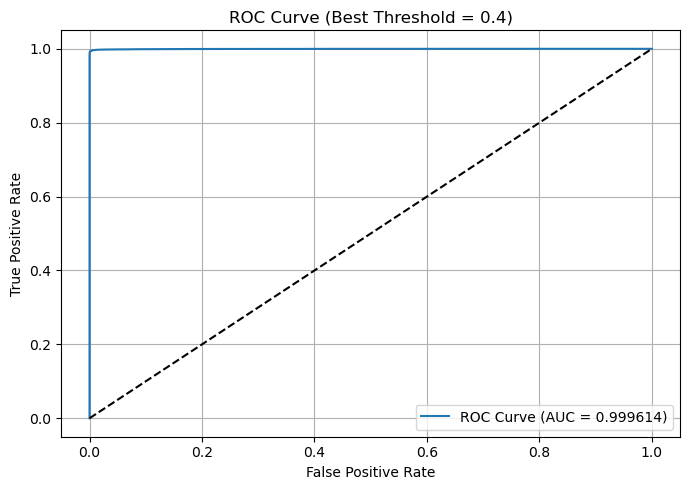

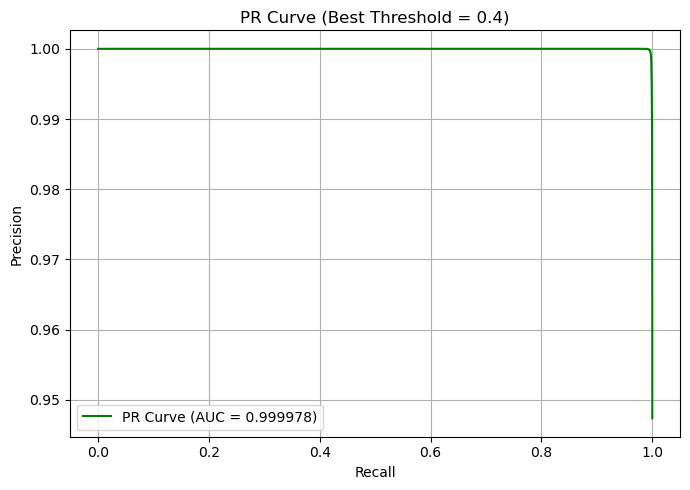

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Logging setup ===
logging.basicConfig(level=logging.INFO)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.info("---Clustering analysis with 5-fold CV on each cluster---")

# === Load dataset ===
df = pd.read_csv("all_features.csv")
df.fillna(0, inplace=True)

# === Prepare X and y ===
X_all = df.drop(columns=["class"])
y_all = df["class"].values

# === Thresholds for clustering ===
thresholds = [0.3, 0.4, 0.5, 0.6]
results_summary = []

# To store the best for curve generation
best_auc = -1
best_curves = {}

# === Main loop ===
for threshold in thresholds:
    n_clusters = int(threshold * 10)
    logging.info(f"Clustering with threshold {threshold} → {n_clusters} clusters")

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_all)

    all_y_true = []
    all_y_scores = []

    # Loop through each cluster
    for cluster_id in range(n_clusters):
        cluster_mask = (cluster_labels == cluster_id)
        X_cluster = X_all[cluster_mask]
        y_cluster = y_all[cluster_mask]

        if len(np.unique(y_cluster)) < 2 or len(y_cluster) < 10:
            # Skip if too small or single-class
            continue

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for train_idx, test_idx in skf.split(X_cluster, y_cluster):
            X_train, X_test = X_cluster.iloc[train_idx], X_cluster.iloc[test_idx]
            y_train, y_test = y_cluster[train_idx], y_cluster[test_idx]

            clf = RandomForestClassifier(n_estimators=100, random_state=42)
            clf.fit(X_train, y_train)

            y_scores = clf.predict_proba(X_test)[:, 1]

            all_y_true.extend(y_test)
            all_y_scores.extend(y_scores)

    # After all clusters are processed
    if len(all_y_true) == 0 or len(np.unique(all_y_true)) < 2:
        continue

    roc_auc = roc_auc_score(all_y_true, all_y_scores)
    pr_auc = average_precision_score(all_y_true, all_y_scores)
    logging.info(f"Threshold {threshold}: ROC-AUC={roc_auc:.6f}, PR-AUC={pr_auc:.6f}")

    results_summary.append({
        "threshold": threshold,
        "n_clusters": n_clusters,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    })

    # Save best for plotting
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_curves = {
            "threshold": threshold,
            "roc_auc": roc_auc,
            "pr_auc": pr_auc,
            "y_true": all_y_true.copy(),
            "y_scores": all_y_scores.copy()
        }

# === Convert results to DataFrame ===
summary_df = pd.DataFrame(results_summary)
summary_df.to_csv("cluster_threshold_summary_result.csv", index=False)
print(summary_df)

# === Plot ROC and PR Curve for Best Threshold ===
y_true = best_curves["y_true"]
y_scores = best_curves["y_scores"]

# ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {best_curves['roc_auc']:.6f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Best Threshold = {best_curves['threshold']})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"PR Curve (AUC = {best_curves['pr_auc']:.6f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR Curve (Best Threshold = {best_curves['threshold']})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


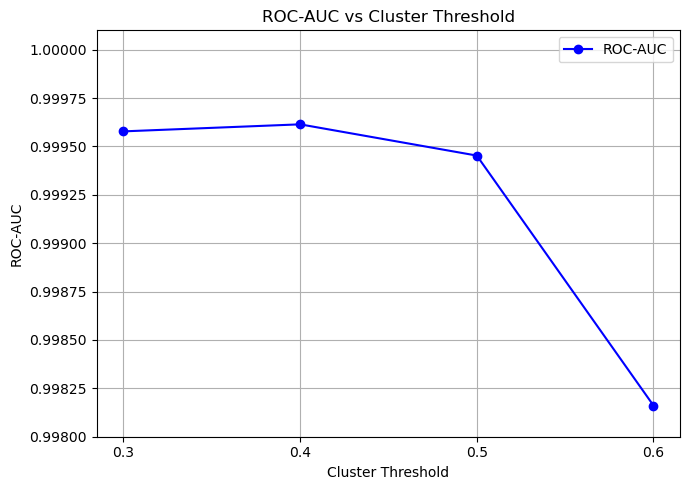

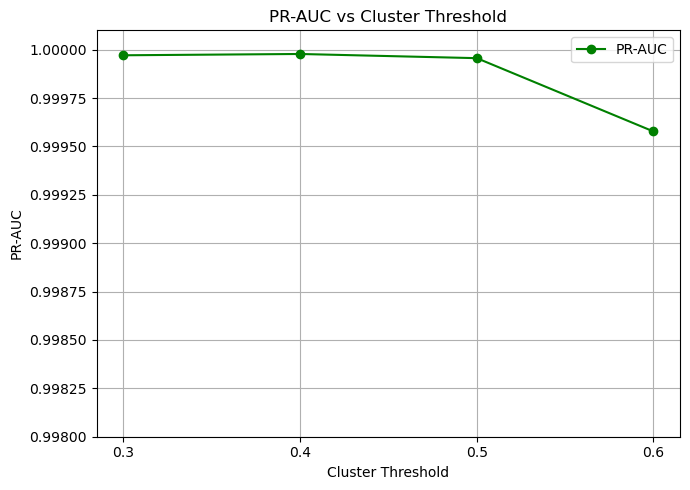

In [12]:
df = pd.read_csv("cluster_threshold_summary_result.csv")

# === 2. Plot ROC-AUC vs Threshold ===
plt.figure(figsize=(7, 5))
plt.plot(df["threshold"], df["roc_auc"], marker='o', color='blue', label="ROC-AUC")
plt.xlabel("Cluster Threshold")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC vs Cluster Threshold")
plt.grid(True)
plt.xticks(df["threshold"])
plt.ylim(0.998, 1.0001)
plt.legend()
plt.tight_layout()
plt.show()

# === 3. Plot PR-AUC vs Threshold ===
plt.figure(figsize=(7, 5))
plt.plot(df["threshold"], df["pr_auc"], marker='o', color='green', label="PR-AUC")
plt.xlabel("Cluster Threshold")
plt.ylabel("PR-AUC")
plt.title("PR-AUC vs Cluster Threshold")
plt.grid(True)
plt.xticks(df["threshold"])
plt.ylim(0.998, 1.0001)
plt.legend()
plt.tight_layout()
plt.show()
